# Import our dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.dates as mdates
import operator
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from funcs import * 

In [2]:



data_df = pd.read_csv('Proj1_Dataset.csv', sep=',', decimal='.')
data_df=parse_date_time(data_df)
data_df = drop_outliners(data_df, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])
data_df = data_df.interpolate(method='linear', limit_direction='forward', axis=0)
#plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)

#group PIR1 and PIR2
data_df['PIR'] =(data_df['PIR1'] | data_df['PIR2'])
#data_df = data_df.drop(['PIR1', 'PIR2'], axis=1)

# iterate between indexes of collumn PIR

data_df["MeanTemp"] = data_df[["S1Temp", "S2Temp","S3Temp"]].mean(axis=1)
data_df["MeanLight"] = data_df[["S1Light", "S2Light","S3Light"]].mean(axis=1)

#data_df to csv
data_df.to_csv('data_df_fuzzy.csv', sep=',', decimal='.', index=False)


#plot_data(data_df, temperature=True, Temp_join=True, CO2=True, PIR=False, PIR_Join = True, light=True, MeanLight=True, persons=True)





Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


# Choose input and output variables

Inputs: "S1Temp", "S2Temp"
        ,"S3Temp","CO2",
        "PIR1", "PIR2",
        "S1Light","S2Light"
        ,"S3Light" 

Output: "Persons" 

/home/lima/.local/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


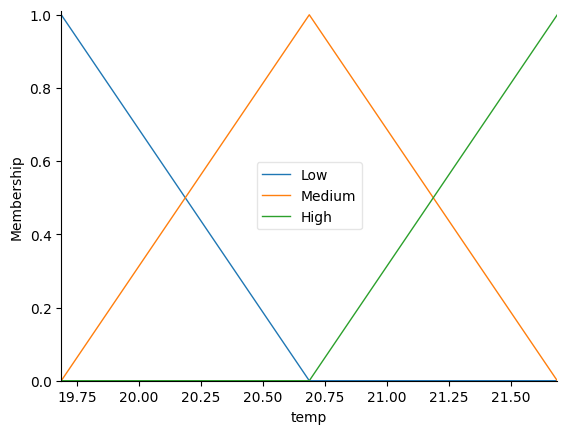

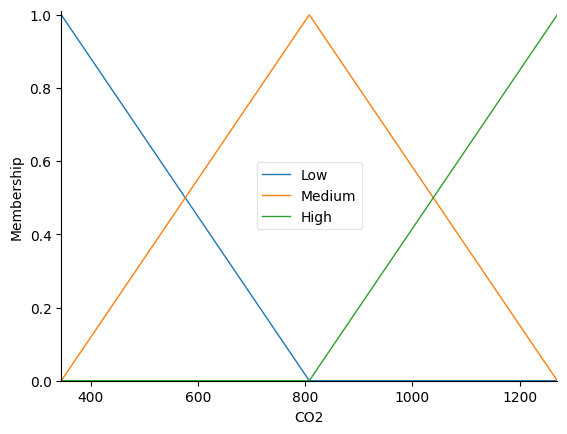

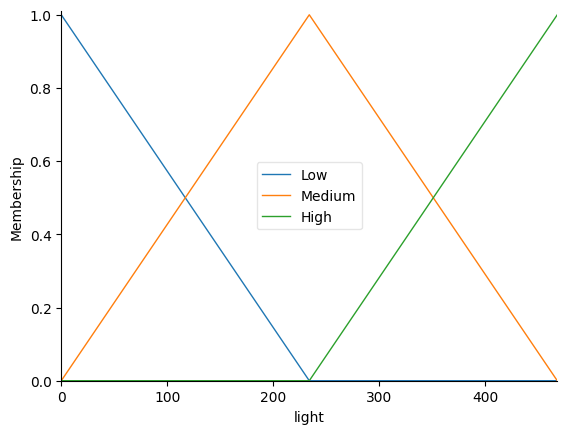

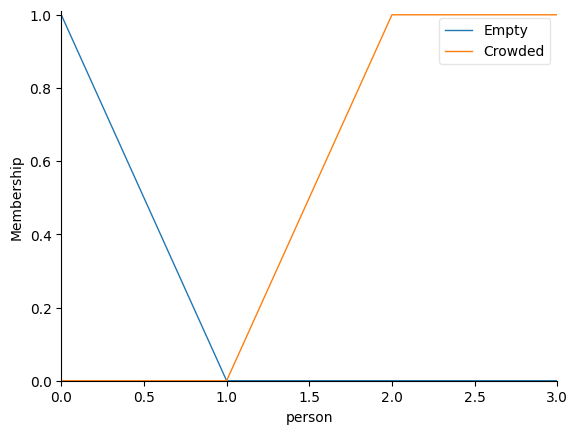

In [3]:


# Generate universe variables
#   * temperature subjective ranges [19, 24]
#   * CO2 subjective ranges [300, 1300]
#   * PIR subjective ranges [0, 1]
#   * light subjective ranges [0, 600]

x_temperature   = np.arange(data_df['MeanTemp'].min(), data_df['MeanTemp'].max(), 1)
x_CO2           = np.arange(data_df['CO2'].min(), data_df['CO2'].max()+1, 1)
x_light         = np.arange(data_df['MeanLight'].min(), data_df['MeanLight'].max()+1, 1)
y_person        = np.arange(data_df['Persons'].min(), data_df['Persons'].max() +1, 1)


temp    = ctrl.Antecedent(x_temperature, 'temp')
CO2     = ctrl.Antecedent(x_CO2, 'CO2')
light   = ctrl.Antecedent(x_light, 'light')
person  = ctrl.Consequent(y_person, 'person')

min = x_temperature.min()
max = x_temperature.max()
med = min+((max-min)/2)

temp['Low'] = fuzz.trimf(temp.universe, [min, min, med])
temp['Medium'] = fuzz.trimf(temp.universe, [min, med, max])
temp['High'] = fuzz.trimf(temp.universe, [med, max, max])

min = x_CO2.min()
max = x_CO2.max()
med = min+((max-min)/2)
CO2['Low'] = fuzz.trimf(CO2.universe, [min, min, med])
CO2['Medium'] = fuzz.trimf(CO2.universe, [min, med, max])
CO2['High'] = fuzz.trimf(CO2.universe, [med, max, max])

min = x_light.min()
max = x_light.max()
med = min+((max-min)/2)
light['Low'] = fuzz.trimf(light.universe, [min, min, med])
light['Medium'] = fuzz.trimf(light.universe, [min, med, max])
light['High'] = fuzz.trimf(light.universe, [med, max, max])


person['Empty'] = fuzz.trimf(person.universe, [-1,0, 1])
#person['Normal'] = fuzz.trimf(person.universe, [0,3/2, 3])
person['Crowded'] = fuzz.trapmf(person.universe, [1.5,2,3,3])

temp.view()
CO2.view()
light.view()
person.view()





In [4]:
# Define rules
rule1 = ctrl.Rule(temp['Low'] & CO2['Low'] & light['Low'], person['Empty'])
rule2 = ctrl.Rule(temp['Low'] & CO2['Low'] & light['Medium'], person['Empty'])
rule3 = ctrl.Rule(temp['Low'] & CO2['Low'] & light['High'], person['Empty'])

rule4 = ctrl.Rule(temp['Low'] & CO2['Medium'] & light['Low'], person['Empty'])
rule5 = ctrl.Rule(temp['Low'] & CO2['Medium'] & light['Medium'], person['Empty'])
rule6 = ctrl.Rule(temp['Low'] & CO2['Medium'] & light['High'], person['Empty'])

rule7 = ctrl.Rule(temp['Low'] & CO2['High'] & light['Low'], person['Empty'])
rule8 = ctrl.Rule(temp['Low'] & CO2['High'] & light['Medium'], person['Empty'])
rule9 = ctrl.Rule(temp['Low'] & CO2['High'] & light['High'], person['Empty'])

rule10 = ctrl.Rule(temp['Medium'] & CO2['Low'] & light['Low'], person['Empty'])
rule11 = ctrl.Rule(temp['Medium'] & CO2['Low'] & light['Medium'], person['Empty'])
rule12 = ctrl.Rule(temp['Medium'] & CO2['Low'] & light['High'], person['Empty'])

rule13 = ctrl.Rule(temp['Medium'] & CO2['Medium'] & light['Low'], person['Empty'])
rule14 = ctrl.Rule(temp['Medium'] & CO2['Medium'] & light['Medium'], person['Normal'])
rule15 = ctrl.Rule(temp['Medium'] & CO2['Medium'] & light['High'], person['Normal'])

rule16 = ctrl.Rule(temp['Medium'] & CO2['High'] & light['Low'], person['Empty'])
rule17 = ctrl.Rule(temp['Medium'] & CO2['High'] & light['Medium'], person['Normal'])
rule18 = ctrl.Rule(temp['Medium'] & CO2['High'] & light['High'], person['Normal'])

rule19 = ctrl.Rule(temp['High'] & CO2['Low'] & light['Low'], person['Empty'])
rule20 = ctrl.Rule(temp['High'] & CO2['Low'] & light['Medium'], person['Empty'])
rule21 = ctrl.Rule(temp['High'] & CO2['Low'] & light['High'], person['Empty'])

rule22 = ctrl.Rule(temp['High'] & CO2['Medium'] & light['Low'], person['Normal'])
rule23 = ctrl.Rule(temp['High'] & CO2['Medium'] & light['Medium'], person['Normal'])
rule24 = ctrl.Rule(temp['High'] & CO2['Medium'] & light['High'], person['Normal'])

rule25 = ctrl.Rule(temp['High'] & CO2['High'] & light['Low'], person['Normal'])
rule26 = ctrl.Rule(temp['High'] & CO2['High'] & light['Medium'], person['Normal'])
rule27 = ctrl.Rule(temp['High'] & CO2['High'] & light['High'], person['Crowded'])

r1 = ctrl.Rule(CO2['Low'] & (light['High'] | light['Medium']), person['Normal'])
r2 = ctrl.Rule(CO2['High'], person['Crowded'])
r3 = ctrl.Rule(CO2['High'] & light['Low'], person['Empty'])
# Create control system
#person_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20, rule21, rule22, rule23, rule24, rule25, rule26, rule27])
person_ctrl = ctrl.ControlSystem([r1, r2, r3])
# Create simulation
person_sim = ctrl.ControlSystemSimulation(person_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
#person_sim.input['temp'] = 24

#import sys


for row in data_df.iterrows():
    try:
        person_sim.input['CO2'] = row[1]['CO2']
        person_sim.input['light'] = row[1]['MeanLight']
        # Crunch the numbers
        person_sim.compute()
        print(person_sim.output['person'])
    except:
        #print the error type
        print("Error:", sys.exc_info()[0])
        continue

    #person.view(sim=person_sim)
#person_sim.input['CO2'] = 500
#person_sim.input['light'] = 1000

# Crunch the numbers
#person_sim.compute()

#print(person_sim.output['person'])
#person.view(sim=person_sim)



 

ValueError: Membership function 'Normal' does not exist for Consequent person.
Available options: 'Empty', or 'Crowded'.

# Rule creation 



In [ ]:
# min = x_temperature.min()
# max = x_temperature.max()
# med = min+((max-min)/2)

# # Generate fuzzy membership functions
# temperature_lo = fuzz.trimf(x_temperature , [min, min, med])
# temperature_md = fuzz.trimf(x_temperature , [min, med, max])
# temperature_hi = fuzz.trimf(x_temperature , [med, max, max])

# min = x_CO2.min()
# max = x_CO2.max()
# med = min+((max-min)/2)

# CO2_lo = fuzz.trimf(x_CO2 , [min, min, med])
# CO2_md = fuzz.trimf(x_CO2 , [min, med, max])
# CO2_hi = fuzz.trimf(x_CO2 , [med, max, max])


# min = x_light.min()
# max=x_light.max()
# med = min+((max-min)/2)
# light_lo = fuzz.trimf(x_light , [min, min, med])
# light_md = fuzz.trimf(x_light , [min, med, max])
# light_hi = fuzz.trimf(x_light , [med, max, max])

# min = y_person.min()
# max = y_person.max()
# med = min+((max-min)/2)
# person_lo = fuzz.trimf(y_person , [min, min, med])
# person_md = fuzz.trimf(y_person , [min, med, max])
# person_hi = fuzz.trimf(y_person , [med, max, max])

# # Visualize these universes and membership functions
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(20,10))

# ax0.plot(x_temperature, temperature_lo, 'b', linewidth=1.5, label='Low')
# ax0.plot(x_temperature, temperature_md, 'g', linewidth=1.5, label='Medium')
# ax0.plot(x_temperature, temperature_hi, 'r', linewidth=1.5, label='High')
# ax0.set_title('Temperature')
# ax0.legend()

# ax1.plot(x_CO2, CO2_lo, 'b', linewidth=1.5, label='Low')
# ax1.plot(x_CO2, CO2_md, 'g', linewidth=1.5, label='Medium')
# ax1.plot(x_CO2, CO2_hi, 'r', linewidth=1.5, label='High')
# ax1.set_title('CO2')
# ax1.legend()

# ax2.plot(x_light, light_lo, 'b', linewidth=1.5, label='Low')
# ax2.plot(x_light, light_md, 'g', linewidth=1.5, label='Medium')
# ax2.plot(x_light, light_hi, 'r', linewidth=1.5, label='High')
# ax2.set_title('Light')
# ax2.legend()

# ax3.plot(y_person, person_lo, 'b', linewidth=1.5, label='Empty')
# ax3.plot(y_person, person_md, 'g', linewidth=1.5, label='Normal')
# ax3.plot(y_person, person_hi, 'r', linewidth=1.5, label='Crowded')
# ax3.set_title('Person')
# ax3.legend()


# # Turn off top/right axes
# for ax in (ax0, ax1, ax2):
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.get_xaxis().tick_bottom()
#     ax.get_yaxis().tick_left()

# plt.tight_layout()

